# Dependencies

In [1]:
import scipy
from scipy.optimize import curve_fit
from scipy.io import wavfile
from scipy import signal
from scipy.signal import butter, sosfiltfilt
import matplotlib.pyplot as plt
from matplotlib import pylab
import math
import pandas as pd
import numpy as np
import osascript
from gtts import gTTS 
import os 
import pyaudio
import wave
import keyboard  # using module keyboard
import soundfile as sf
import pyloudnorm as pyln
from sys import byteorder
from array import array
from struct import pack
import time
import subprocess
import pyttsx3
import tkinter

# Constants

In [2]:
THRESHOLD = 100
CHUNK_SIZE = 2048
FORMAT = pyaudio.paInt16
RATE = 44100
AVG_STEP = 75
PERCENTILE = 70
BANDPASS_FREQ = [300, 3400]
CALIBRATION_VOLUME = 40

# Record Audio

#### Record from microphone

 Record a word or words from the microphone and return the data as an array of signed shorts.

In [3]:
def record():
    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT, channels=1, rate=RATE,
        input=True, output=True,
        frames_per_buffer=CHUNK_SIZE)
    num_silent = 0
    snd_started = False
    r = array('h')

    while 1:
        snd_data = array('h', stream.read(CHUNK_SIZE)) # little endian, signed short
        if byteorder == 'big':
            snd_data.byteswap()
        r.extend(snd_data)

        silent = is_silent(snd_data)

        if silent and snd_started:
            num_silent += 1
        elif not silent and not snd_started:
            snd_started = True

        if snd_started and num_silent > 60:
            break

    sample_width = p.get_sample_size(FORMAT)
    stream.stop_stream()
    stream.close()
    p.terminate()
    return sample_width, r

#### Save to wav file

In [4]:
def record_to_file(path):
    sample_width, data = record()
    data = pack('<' + ('h'*len(data)), *data)

    wf = wave.open(path, 'wb')
    wf.setnchannels(1)
    wf.setsampwidth(sample_width)
    wf.setframerate(RATE)
    wf.writeframes(data)
    wf.close()

#### Checks if input is silent based on threshold

In [5]:
def is_silent(snd_data):
    "Returns 'True' if below the 'silent' threshold"
    return max(snd_data) < THRESHOLD

# Preprocessing

# Filters

In [6]:
def voice_input_band(voice_data):
    fs, data = wavfile.read(voice_data)
    data = butter_bandpass_filter(data, BANDPASS_FREQ[0], BANDPASS_FREQ[1], fs)
    return data, fs

#### Implement butter bandpass filter

In [7]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='band', analog=False, output='sos')
    return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfiltfilt(sos, data)
    return y

# Loudness Algorithm

#### Get amplitude curve and apply regression on ITU-R BS.1770-4 loudness algorithm

In [8]:
def getting_loudness3(data, rate):
    plt.figure(0)
    plt.plot(data)
    
    # Average data by step size to percentile
    avg_data = np.percentile(data[:(len(data)//AVG_STEP)*AVG_STEP].reshape(-1,AVG_STEP),
                             PERCENTILE, axis=1)
    
    #apply hilbert envelope
    hilbert_transformed = np.abs(scipy.signal.hilbert(avg_data))

    #Smooth out hilbert 
    b, a = scipy.signal.ellip(4, 0.01, 120, 0.125)
    fgust = scipy.signal.filtfilt(b, a, hilbert_transformed, method="gust")
    plt.figure(1)
    plt.plot(avg_data)
    plt.plot(fgust)

    #remove silence 
    avg = np.mean(fgust)
    silenced = remove_silence_from(fgust, avg)
    plt.figure(2)
    plt.plot(silenced)
    data = [float(i) for i in silenced]
    data = np.array(data)

    # measure the loudness first 
    meter = pyln.Meter(rate/500) # create BS.1770 meter
    loudness = meter.integrated_loudness(data)
#     print("lds: "+ str(loudness))
    #return the exponential regression
    return (loudness)

#### Remove silence before, after, and in-between voice data

In [9]:
def remove_silence_from(amplitudes, threshold):
    silenced = []
    for x in amplitudes:
        if x >= threshold:
            silenced.append(x)
    return silenced# Preprocessing

# Regressions

#### Regression converts loudness to scale 0 to 100 and adjusts for calibration offset

In [10]:
def regression(loudness, offset=0):
    return 2.1256619652039683 * loudness + 52.66548772500079 - offset

# Calibration

In [11]:
def get_offset(calib_loudness):
    return calib_loudness - CALIBRATION_VOLUME

# Response

#### Sets a new volume that is spoken at for the user

In [12]:
def reply(user_volume):
    speaker_volume = int(osascript.osascript('output volume of (get volume settings)')[1])
    print("speaker volume is " + str(speaker_volume))
    print("user volume is "+ str(user_volume))
    if(speaker_volume < user_volume):
        new_volume = speaker_volume + (((speaker_volume - user_volume)**2) /100)
    else:
        new_volume = speaker_volume - (((speaker_volume - user_volume)**2) /100)
    print("speaker new volume is " + str(new_volume))
    osascript.osascript("set volume output volume "+ str(new_volume)) 
    thing_to_say = 'hello your volume is at '+ str(int(new_volume))
    print(thing_to_say)
    return int(osascript.osascript('output volume of (get volume settings)')[1])

# GUI


#### Initial Values

In [13]:
offset = 0
speaker_volume = int(osascript.osascript('output volume of (get volume settings)')[1])
user_volume = 0

#### Button Functions

In [14]:
def calibration():
    record_to_file('calibrate.wav')
    data, rate = voice_input_band('calibrate.wav')
    calib_loudness = getting_loudness3(data, rate)
    calib_loudness = regression(calib_loudness)
    offset = get_offset(calib_loudness)
    status_button.insert('1.0', 
    str(time.strftime('%l:%M%p %Z on %b %d, %Y'))+': -  CALIBRATED, offset: '+str(int(offset))+'\n')
    say_something('done calibrating')
#     print("last bit of calibration")

In [15]:
def recording():
    #calculating volume
    speaker_volume = int(osascript.osascript('output volume of (get volume settings)')[1])
    record_to_file('demo.wav')
    status_button.insert('1.0', 
    str(time.strftime('%l:%M%p %Z on %b %d, %Y'))+': -  Done recording \n')
    data, rate = voice_input_band('demo.wav')
    user_volume = getting_loudness3(data, rate)
    user_volume = regression(user_volume, offset)
    user_volume_button["text"] = "user volume: "+str(int(user_volume))
    new_volume = reply(int(user_volume))
    if new_volume > speaker_volume:
        thing_to_say = 'hello, the volume increased from '+str(speaker_volume)+' to '+str(int(new_volume))
    else:
        thing_to_say = 'hello, the volume decreased from '+str(speaker_volume)+' to '+str(int(new_volume))
    speaker_volume = int(osascript.osascript('output volume of (get volume settings)')[1])
    speaker_volume_button["text"] = "speaker volume: "+str(int(speaker_volume))
    say_something(thing_to_say)

#### Main

In [1]:
engine = pyttsx3.init()
def say_something(thing_to_say):
    subprocess.run(["say", thing_to_say])
def say_athing(things_to_say):
    os.system("say "+things_to_say)
def say(s):
    engine = pyttsx3.init()
    rate = engine.getProperty('rate')
    engine.setProperty('rate', rate)
    voices= engine.getProperty('voices')
    #for voice in voices:
    engine.setProperty('voice', 'english-us')
    #print voice.id                                  
    engine.say(s)
    a = engine.runAndWait() #blocks     

NameError: name 'pyttsx3' is not defined

speaker volume is 19
user volume is 20
speaker new volume is 19.01
hello your volume is at 19


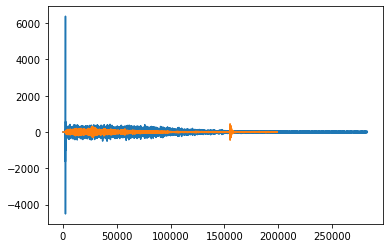

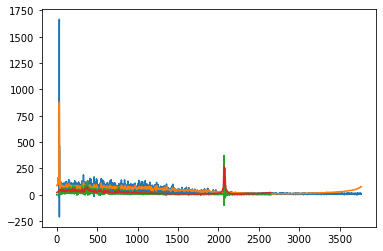

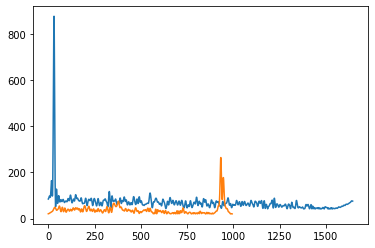

In [17]:
gui = tkinter.Tk()
speaker_volume_button = tkinter.Label(gui,  text ="speaker volume: "+str(speaker_volume))
speaker_volume_button.pack()
user_volume_button = tkinter.Label(gui,  text ="user volume: "+str(user_volume))
user_volume_button.pack()
status_button = tkinter.Text(gui)
status_button.pack()
calibrate = tkinter.Button(gui,  text ="calibrate", padx = 90, pady = 60, command = calibration)
calibrate.pack()
record_button = tkinter.Button(gui,  text ="record", padx = 90, pady = 60, command = recording)
record_button.pack()
status_button.insert('1.0', 
    str(time.strftime('%l:%M%p %Z on %b %d, %Y'))+': -  program started \n')
gui.mainloop()

# Main

In [ ]:
if __name__ == '__main__':
    #calibration
    os.system("say "+ "Please speak at a normal room volume for calibration")
    print("Please speak at a normal room volume for calibration")
    record_to_file('calibrate.wav')
    data, rate = voice_input_band('calibrate.wav')
    calib_loudness = getting_loudness3(data, rate)
    print("Calib loudness: " + str(int(calib_loudness)))
    calib_loudness = regression(calib_loudness)
    print("Calib loudness: " + str(int(calib_loudness)))
    offset = get_offset(calib_loudness)
    print("Offset: " + str(offset))
    
    #calculating volume
    os.system("say "+ "Please speak into the microphone")
    print("please speak a word into the microphone")
    record_to_file('demo.wav')
    print("done - result written to demo.wav")
    data, rate = voice_input_band('demo.wav')
    new_volume = getting_loudness3(data, rate)
    new_volume = regression(new_volume, offset)
    os.system("say "+ "Your volume is" + str(int(new_volume)))
#     reply(int(new_volume))

Please speak at a normal room volume for calibration
